## Project 4 Coronavirus Goes Randomly Viral

##### Group Members: Lars Olav Thorbjørnsen, Stein Are Årsnes og Sanjai Vijeyaratnam

### Abstract

This project explores the modeling of an epidemic outbreak using two distinct approaches: a stochastic random-walk simulation and deterministic ordinary differential equation (ODE) models. The random-walk model, an agent-based simulation, tracks individual movements and interactions on a 2D lattice, simulating disease transmission events. The SI and SIR models, on the other hand, aggregate population-level dynamics into compartments governed by ODEs, providing a broader perspective on disease spread.

Our work compares these models under various conditions, incorporating factors such as recovery, reinfection, vaccination, and death rates. We found that while both models yield similar long-term outcomes, the random-walk model captures greater variability and spatial interactions, resulting in more gradual transitions and uncertainty in early stages. Extensions to the base models, including vaccination and age-based mortality, demonstrated significant impacts on infection and death rates, highlighting the complex interplay of individual behaviors and public health measures. This study provides a deeper understanding of disease dynamics and illustrates the strengths of both stochastic and deterministic approaches for epidemic modeling.

### Introduction 

The Covid-19 pandemic highlighted the critical role of mathematical models in predicting and managing infectious disease outbreaks. These models range from fine-grained, stochastic simulations that mimic individual behavior to deterministic compartment models that analyze population-level dynamics. This project combines these perspectives to study the spread of a contagious disease using a stochastic random-walk approach on a 2D lattice and compares its outcomes to classical ODE-based SI and SIR models.

The random-walk simulation represents individuals as agents moving randomly on a constrained spatial grid, interacting with others to propagate the infection. The deterministic models simplify these dynamics by modeling population compartments (e.g., Susceptible, Infected, Recovered, Dead) using rate equations. Both approaches help elucidate the mechanisms underlying disease transmission, but they differ in granularity, assumptions, and computational complexity. This project examines the dynamics of a basic SI model, incorporates extensions like recovery and vaccination, and evaluates the impact of assumptions through quantitative and visual comparisons.

### Exercise 1


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.integrate import odeint

In [2]:
class RandomWalkSIModel:
    def __init__(self, nx=50, ny=50, N=688, q=0.9, initial_infected=1, p_recover=0, p_vaccinate=0, p_death=0, reinfection=0, wave_period=0, wave_amplitude=0, p_death_vaccinated=0, p_recover_vaccinated=0,  
                vaccine_start_time= 0, old_age_ratio=0, old_death_multiplier=0, old_stay_home_prob=0, home_radius=0):
        self.nx = nx
        self.ny = ny 
        self.N = N 
        self.q = q 
        self.initial_infected = initial_infected
        self.p_recover = p_recover
        self.p_recover_vaccinated = p_recover_vaccinated
        self.p_vaccinate = p_vaccinate 
        self.p_death = p_death
        self.p_death_vaccinated = p_death_vaccinated
        self.vaccine_start_time = vaccine_start_time
        self.reinfection = reinfection
        self.wave_period = wave_period
        self.wave_amplitude = wave_amplitude
        self.old_age_ratio = old_age_ratio
        self.old_death_multiplier = old_death_multiplier
        self.old_stay_home_prob = old_stay_home_prob
        self.home_radius = home_radius
        
        self.positions = np.random.randint(0, nx, size=(N, 2))
        self.states = np.zeros(N, dtype=int)

        self.ages = np.random.choice([0, 1], size=N, p=[1 - self.old_age_ratio, self.old_age_ratio])

        infected_indices = np.random.choice(np.arange(self.N), size=self.initial_infected, replace=False)
        self.states[infected_indices] = 1

        # Old people's "home" area
        self.home_positions = self.positions.copy()
        
        self.history_S = []
        self.history_I = []
        self.history_R = []
        self.history_V = []
        self.history_D = []
        self.history_VI = []
        self.beta_estimates = []

    def move_walkers(self):
        """Move each walker randomly to one of the four neighboring nodes."""
        directions = np.random.randint(0, 4, size=self.N)
        dx = np.zeros(self.N, dtype=int)
        dy = np.zeros(self.N, dtype=int)

        dy[directions == 0] = 1
        dy[directions == 1] = -1
        dx[directions == 2] = 1
        dx[directions == 3] = -1

        stationary = (self.ages == 1) & (np.random.random(self.N) < self.old_stay_home_prob)
        dx[stationary] = 0
        dy[stationary] = 0

        home_dist = np.linalg.norm(self.positions - self.home_positions, axis=1)
        outside_home = (self.ages == 1) & (home_dist > self.home_radius)
        self.positions[outside_home] = self.home_positions[outside_home]

        self.positions[:, 0] += dx
        self.positions[:, 1] += dy

        self.positions[:, 0] = np.clip(self.positions[:, 0], 0, self.nx - 1)
        self.positions[:, 1] = np.clip(self.positions[:, 1], 0, self.ny - 1)

    def update_infections(self):
        """Update the infection state based on walker interactions."""
        if self.wave_period > 0:
            current_q = self.q + (self.wave_amplitude * np.sin(2 * np.pi * len(self.history_I) / self.wave_period))
        else:
            current_q = self.q
        position_map = defaultdict(list)
        for idx, pos in enumerate(self.positions):
            pos_tuple = tuple(pos)
            position_map[pos_tuple].append(idx)
        for walkers in position_map.values():
            if len(walkers) > 1:
                infected_present = np.any(self.states[walkers] == 1)
                infected_and_vaccinated_present = np.any(self.states[walkers] == 5)
                if infected_present or infected_and_vaccinated_present:
                    for idx in walkers:
                        if self.states[idx] == 0:
                            if np.random.random() < current_q:
                                self.states[idx] = 1
                        elif self.states[idx] == 3 and self.p_recover_vaccinated > 0:  
                            if np.random.random() < self.q/3:  
                                self.states[idx] = 5

    def recover_individuals(self):
        """Recover infected individuals with probability p_recover."""
        for i in range(self.N):
            if self.states[i] == 1 and np.random.random() < self.p_recover:
                self.states[i] = 2
            elif self.states[i] == 5 and np.random.random() < self.p_recover_vaccinated:
                self.states[i] = 3
            elif self.states[i] == 2 and np.random.random() < self.reinfection:
                self.states[i] = 0
    
    def vaccinate(self, step):
        """Vaccinate susceptible individuals with probability p_vaccinate."""
        if step >= self.vaccine_start_time:
            for i in range(self.N):
                if self.states[i] == 0 and np.random.random() < self.p_vaccinate:
                    self.states[i] = 3

    def kill_individuals(self):
        """Kill infected individuals with probability p_death."""
        self.young_deaths = 0  # Track deaths in young individuals
        self.old_deaths = 0    # Track deaths in old individuals

        for i in range(self.N):
            if self.states[i] == 1:
                death_probability = self.p_death
                if self.ages[i] == 1:  # Old individuals
                    death_probability *= self.old_death_multiplier
                if np.random.random() < death_probability:
                    self.states[i] = 4
                    if self.ages[i] == 1:
                        self.old_deaths += 1
                    else:
                        self.young_deaths += 1
            elif self.states[i] == 5 and np.random.random() < self.p_death_vaccinated:
                    self.states[i] = 4

    def estimate_beta(self, step):
        """Estimate beta for the current step based on the change in S."""
        if step > 0:
            S_t = self.history_S[step]
            S_t_prev = self.history_S[step - 1]
            I_t = self.history_I[step]
            if S_t > 0 and I_t > 0:
                beta_t = - (S_t - S_t_prev) / (S_t * I_t) * self.N
                self.beta_estimates.append(beta_t)
        
    def run_simulation(self, num_runs=100, steps=300, initial_infected=10, p_recover=0, p_vaccinate=0, p_death=0, reinfection=0, wave_period=0, wave_amplitude=0, p_death_vaccinated=0, p_recover_vaccinated=0,
                       vaccine_start_time =0, old_age_ratio=0, old_death_multiplier=0, old_stay_home_prob=0, home_radius=0):
        """Run the simulation for a given number of time steps."""
        history_S = np.zeros((num_runs, steps))
        history_I = np.zeros((num_runs, steps))
        history_R = np.zeros((num_runs, steps))
        history_V = np.zeros((num_runs, steps))
        history_D = np.zeros((num_runs, steps))
        history_VI = np.zeros((num_runs, steps))
        beta_values = []

        total_young_deaths = np.zeros(steps)
        total_old_deaths = np.zeros(steps)
        
        for i in range(num_runs):
            self.__init__(nx=self.nx, ny=self.ny, N=self.N, q=self.q, initial_infected=initial_infected, p_recover=p_recover, p_vaccinate=p_vaccinate, p_death=p_death, reinfection=reinfection, wave_period=wave_period, wave_amplitude=wave_amplitude, p_death_vaccinated=p_death_vaccinated, p_recover_vaccinated=p_recover_vaccinated, 
                          vaccine_start_time=vaccine_start_time, old_age_ratio=old_age_ratio, old_death_multiplier=old_death_multiplier, old_stay_home_prob=old_stay_home_prob, home_radius=home_radius)
            for step in range(steps):
                self.move_walkers()
                self.update_infections()
                self.recover_individuals()
                self.vaccinate(step)
                self.kill_individuals()

                # Accumulate deaths by age group
                total_young_deaths[step] += self.young_deaths
                total_old_deaths[step] += self.old_deaths

                self.history_S.append(np.sum(self.states == 0))
                self.history_I.append(np.sum(self.states == 1))
                self.history_R.append(np.sum(self.states == 2))
                self.history_V.append(np.sum(self.states == 3))
                self.history_D.append(np.sum(self.states == 4))
                self.history_VI.append(np.sum(self.states == 5))

                self.estimate_beta(step)

            history_S[i] = self.history_S
            history_I[i] = self.history_I
            history_R[i] = self.history_R
            history_V[i] = self.history_V
            history_D[i] = self.history_D
            history_VI[i] = self.history_VI

            beta_values.append(np.mean(self.beta_estimates) if self.beta_estimates else 0)

        mean_S = np.mean(history_S, axis=0)
        std_S = np.std(history_S, axis=0)
        mean_I = np.mean(history_I, axis=0)
        std_I = np.std(history_I, axis=0)
        mean_R = np.mean(history_R, axis=0)  
        std_R = np.std(history_R, axis=0)
        mean_V = np.mean(history_V, axis=0)
        std_V = np.std(history_V, axis=0)
        mean_D = np.mean(history_D, axis=0)
        std_D = np.std(history_D, axis=0)
        mean_VI = np.mean(history_VI, axis=0)
        std_VI = np.std(history_VI, axis=0)

        mean_beta = np.mean(beta_values)
        print(f"Estimated β: {mean_beta}")
        if old_death_multiplier > 0:
            print("Age-specific deaths:")
            print(f"Young deaths (total): {np.sum(total_young_deaths)/num_runs}")
            print(f"Old deaths (total): {np.sum(total_old_deaths)/num_runs}")

        return mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, mean_beta
    
    def plot_results(self, mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D,  mean_VI, std_VI, steps):
        """Plot the results of the simulation."""
        time = np.arange(steps)
        plt.figure(figsize=(10, 6))
        
        plt.plot(time, mean_S, label='Susceptible (mean)', color='blue')
        plt.fill_between(time, mean_S - std_S, mean_S + std_S, color='blue', alpha=0.3)
        
        plt.plot(time, mean_I, label='Infected (mean)', color='red')
        plt.fill_between(time, mean_I - std_I, mean_I + std_I, color='red', alpha=0.3)

        plt.plot(time, mean_R, label='Recovered (mean)', color='yellow')  
        plt.fill_between(time, mean_R - std_R, mean_R + std_R, color='yellow', alpha=0.3)

        plt.plot(time, mean_V, label='Vaccinated (mean)', color='green')
        plt.fill_between(time, mean_V - std_V, mean_V + std_V, color='green', alpha=0.3)

        plt.plot(time, mean_D, label='Dead (mean)', color='black')
        plt.fill_between(time, mean_D - std_D, mean_D + std_D, color='black', alpha=0.3)

        plt.plot(time, mean_VI, label='Vaccinated but Infected (mean)', color='purple')
        plt.fill_between(time, mean_VI - std_VI, mean_VI + std_VI, color='purple', alpha=0.3)
        
        plt.xlabel('Time Steps')
        plt.ylabel('Population')
        plt.title('Population Dynamics with Uncertainty')
        plt.legend()
        plt.grid()
        plt.show()

    def solve_ode_si_model(self, beta, S0, I0, steps):
        """Solve the SI model using the ODE approach."""
        def si_model(y, t, beta):
            S, I = y
            dSdt = -beta * S * I / self.N
            dIdt = beta * S * I / self.N
            return [dSdt, dIdt]
        
        y0 = [S0, I0]
        t = np.linspace(0, steps, steps)
        sol = odeint(si_model, y0, t, args=(beta,))
        S, I = sol.T

        return S, I

    def solve_ode_sir_model(self, beta, tau_sick, S0, I0, R0, steps):
        """Solve the SIR model using the ODE approach."""
        def sir_model(y, t, beta, tau_sick):
            S, I, R = y
            dSdt = -beta * S * I / self.N
            dIdt = beta * S * I / self.N - I / tau_sick
            dRdt = I / tau_sick
            return [dSdt, dIdt, dRdt]
        
        y0 = [S0, I0, R0]
        t = np.linspace(0, steps, steps)
        sol = odeint(sir_model, y0, t, args=(beta, tau_sick))
        S, I, R = sol.T

        return S, I, R
    
    def compare_with_ode_sir(self, num_runs=100, steps=700, initial_infected=10, p_recover=0.01):
        """Run the simulation and compare with the ODE solution."""
        mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_v, std_V, mean_D, std_D, mean_VI, std_VI, mean_beta = self.run_simulation(num_runs, steps, initial_infected, p_recover)
        
        S0 = self.N - initial_infected
        I0 = initial_infected
        R0 = 0
        tau_sick = 1 / p_recover
        S_ode, I_ode, R_ode = self.solve_ode_sir_model(mean_beta, tau_sick, S0, I0, R0, steps)
        time = np.arange(steps)

        plt.figure(figsize=(10, 6))
        plt.plot(time, mean_S, label='Susceptible (mean, random walk)', color='blue')


        plt.plot(time, mean_I, label='Infected (mean, random walk)', color='red')


        plt.plot(time, mean_R, label='Recovered (mean, random walk)', color='yellow')


        plt.plot(time, S_ode, '--', label='Susceptible (ODE)', color='green')
        plt.plot(time, I_ode, '--', label='Infected (ODE)', color='orange')
        plt.plot(time, R_ode, '--', label='Recovered (ODE)', color='purple')

        plt.xlabel('Time Steps')
        plt.ylabel('Population')
        plt.title('Comparison of Random Walk and ODE-based SIR Models')
        plt.legend()
        plt.grid()
        plt.show
    
    def compare_with_ode(self, num_runs=100, steps=300, initial_infected=10):
        """Run the simulation and compare with the ODE solution."""
        mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, mean_beta = self.run_simulation(num_runs, steps, initial_infected)
        
        S0 = self.N - initial_infected
        I0 = initial_infected
        S_ode, I_ode = self.solve_ode_si_model(mean_beta, S0, I0, steps)
        time = np.arange(steps)

        plt.figure(figsize=(10, 6))
        plt.plot(time, mean_S, label='Susceptible (mean, random walk)', color='blue')
        plt.fill_between(time, mean_S - std_S, mean_S + std_S, color='blue', alpha=0.3)

        plt.plot(time, mean_I, label='Infected (mean, random walk)', color='red')
        plt.fill_between(time, mean_I - std_I, mean_I + std_I, color='red', alpha=0.3)

        plt.plot(time, S_ode, '--', label='Susceptible (ODE)', color='green')
        plt.plot(time, I_ode, '--', label='Infected (ODE)', color='orange')

        plt.xlabel('Time Steps')
        plt.ylabel('Population')
        plt.title('Comparison of Random Walk and ODE-based SI Models')
        plt.legend()
        plt.grid()
        plt.show()

This is the code for our random-walk model that simulates the spread of an infectious disease on a 2D grid combined with probabilistic state changes. It contains several variables and functions, allowing us to run different simulations based on various inputs. This approach lets us reuse the same class across the different exercises. 

The move walkers method simulates movement by randomly changing positions in one of the four cardinal directions. Update infections method groups individuals by position. If any infected individual is present at a location, susceptible individuals at that location become infected with probability q. Recover individuals, vaccinate and kill individuals methods handles state changes to Recovered, Vaccinated and Dead based on their respective probabilities. Estimate beta, calculates the infection rate $\Beta$ using the change in the susceptible population between time steps. In the end we have a run simulation method that executes the random walk-based infection model over multiple time steps and runs.

#### Initial infected set to 1

Estimated β: 0.04325797521111351


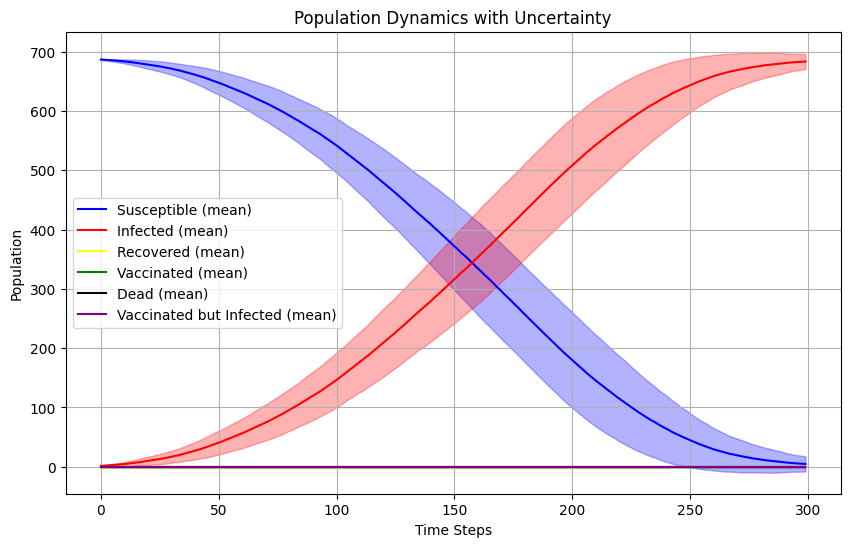

In [3]:
model = RandomWalkSIModel()
mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, mean_beta = model.run_simulation(num_runs=100, steps=300, initial_infected=1, p_recover=0, p_vaccinate=0, p_death=0, reinfection=0, wave_period=0, wave_amplitude=0, p_death_vaccinated=0, p_recover_vaccinated=0,
                    vaccine_start_time=0, old_age_ratio=0, old_death_multiplier=0, old_stay_home_prob=0, home_radius=0)
model.plot_results(mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, steps=300) 

We call on the class with no recovery, vaccination or death and only one infected with a infection probability of 0.9. The graph flows similarly to the example from project sheet, where the society slowly grows more and more infected until everyone is infected.

#### Initial infected set to 10

Estimated β: 0.07036053147442188


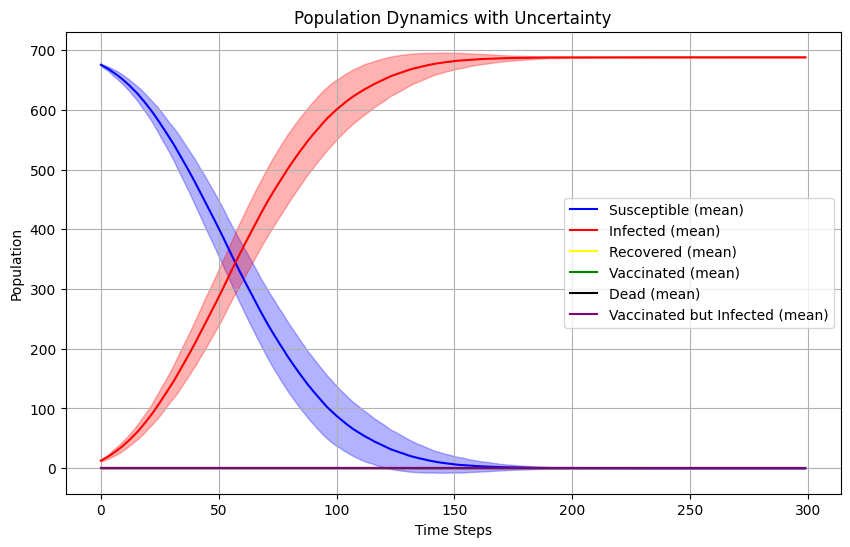

In [4]:
mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, mean_beta = model.run_simulation(num_runs=100, steps=300, initial_infected=10, p_recover=0, p_vaccinate=0, p_death=0, reinfection=0, wave_period=0, wave_amplitude=0, p_death_vaccinated=0, p_recover_vaccinated=0, 
                vaccine_start_time=0, old_age_ratio=0, old_death_multiplier=0, old_stay_home_prob=0, home_radius=0)
model.plot_results(mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, steps=300)

We increase the number of people infected at the start to 10 people. We see that both the susceptible and infected changes like we saw before but at twice the rate. So now our population gets infected much faster. This is because if we only have one infected the chance of someone being at the same location as this infected is quite small, we have a map of 2500 locations and only 688 people. When we change the initial infected to 10 people the chance of an individual being at the same location as an infected is now 10 times higher and the spread therefore is also faster.  

### Exercise 2

#### SI ODE vs random-walk 

Estimated β: 0.07325014859531853


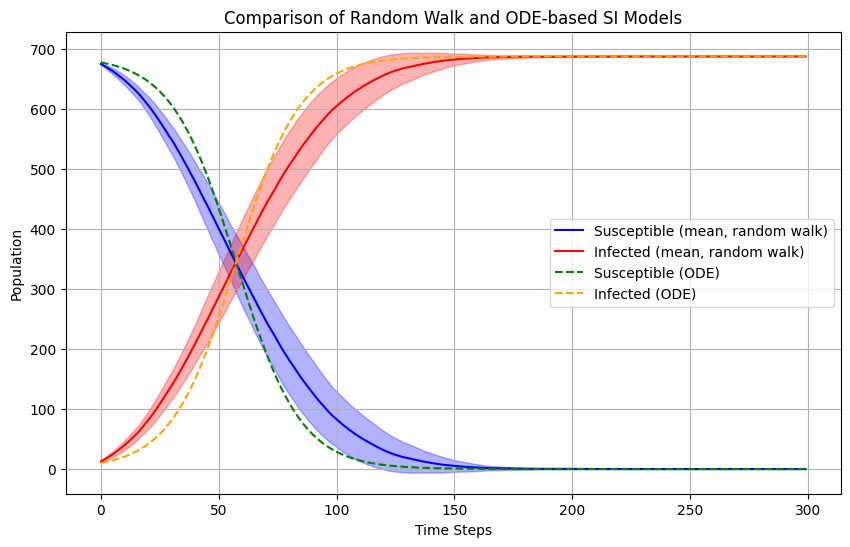

In [5]:
model = RandomWalkSIModel()
model.compare_with_ode(num_runs=100, steps=300, initial_infected=10)

To calculate the ODE model we use the method called solve_ode_si_model, to be able to use this we need to estimate $\Beta$. We make some assumptions: people make the same number of contacts regardless of population size, people make the same amount of contacts independent of time, and the probability of becoming infected never change. We estimate $\Beta$ from our random walk simulation and use it in the ODE method, then we plot the ODE model against our model using the compare_with_ode method. 

We see from the graph that our model has steeper graphs and changes more quickly, but other than that they are quite similar. We also see that our uncertainty, visualized by the gray shaded lines, at the end with both infected and susceptible are very close to the ODE model (time step 75-125). We also see that all graphs cross in the same point, so for one value all graphs are the same.

#### Recovering

Estimated β: 0.09146131975187606


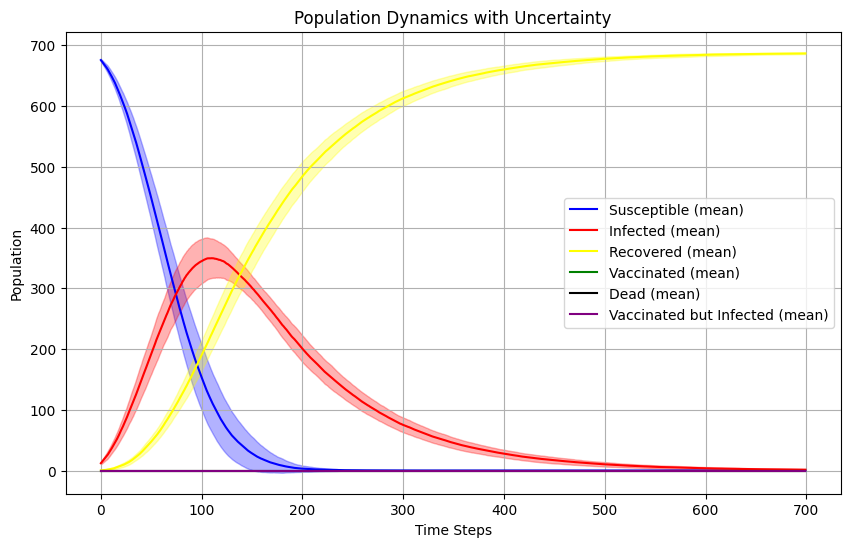

In [6]:
mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, mean_beta = model.run_simulation(num_runs=100, steps=700, initial_infected=10, p_recover=0.01, p_vaccinate=0, p_death=0, reinfection=0, wave_period=0, wave_amplitude=0, p_death_vaccinated=0, p_recover_vaccinated=0, 
                vaccine_start_time=0, old_age_ratio=0, old_death_multiplier=0, old_stay_home_prob=0, home_radius=0)
model.plot_results(mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, steps=700)

We now add the possibility of being able to recover from being infected. We see that this has a dramatic effect on our graph. We see that the number of recovered is going towards the number of total population, this is because in the end everyone get infected and then recovers. The infected graph reaches a max-value at around a 100 time steps and then starts to fall. 

#### SIR ODE vs random-walk 

Estimated β: 0.08649541133869182


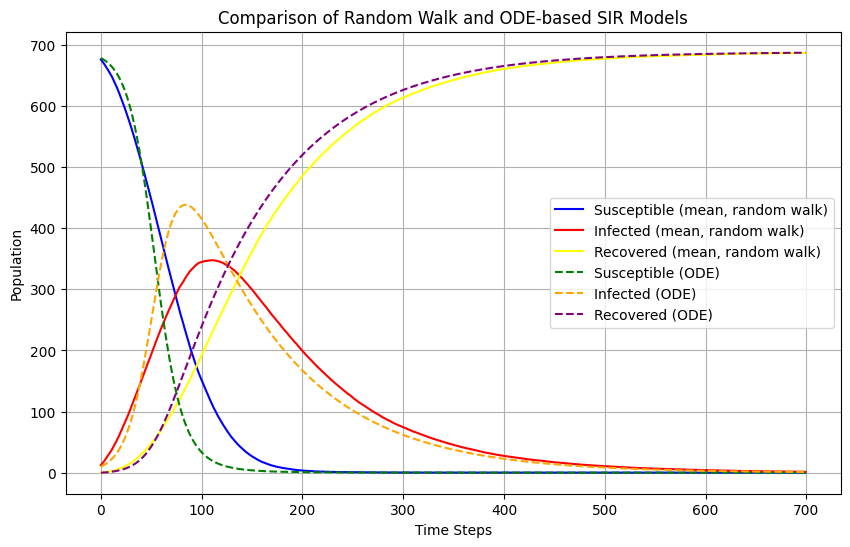

In [7]:
model = RandomWalkSIModel()
model.compare_with_ode_sir(num_runs=100, steps=700, initial_infected=10, p_recover=0.01)

To calculate the SIR ODE model we use the solve_ode_sir_model method which takes in a $\Beta$ same as the SI model, but also takes in a tau_sick value. This value is used to calculate how long it takes for an individual to recover from being infected. We use the compare_with_ode_sir method to compare it to our random walk model. At first sight we see clear differences in steepness of the graphs, the SIR ODE graphs are steeper than the random walk graphs. This difference in steepness changes the number of infected at a single moment of time, we see that the ODE based model has a higher number of infected but again it drops much faster than our random walk model. The difference in number of recovered is not large, even tho people are infected faster, the recovery rate is about the same, only a little bit higher in the start. The models are different, but again the outcome is the same, only difference is the time.

### Exercise 3
#### Introducing deaths

Estimated β: 0.09092898198388541


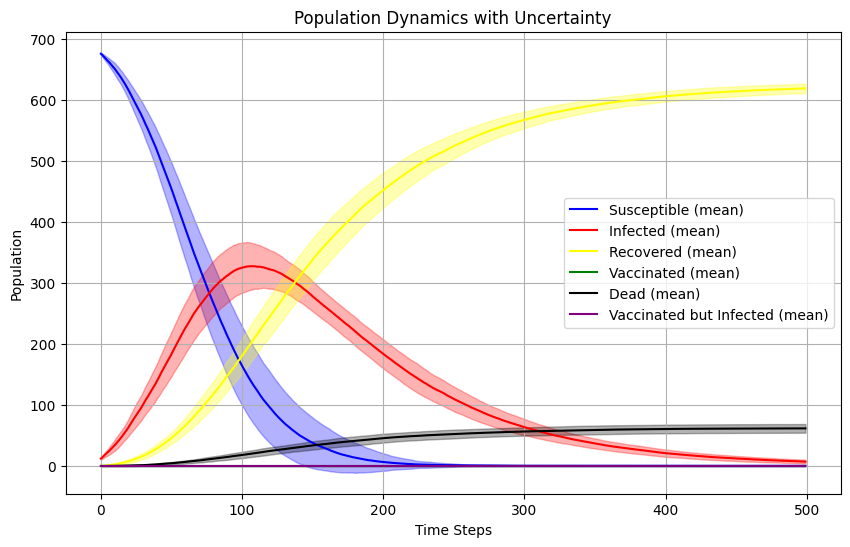

In [8]:

mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, mean_beta = model.run_simulation(num_runs=100, steps=500, initial_infected=10, p_recover=0.01, p_vaccinate=0, p_death=0.001, reinfection=0, wave_period=0, wave_amplitude=0, p_death_vaccinated=0, p_recover_vaccinated=0,
                vaccine_start_time=0, old_age_ratio=0, old_death_multiplier=0, old_stay_home_prob=0, home_radius=0)
model.plot_results(mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, steps=500)

Lets implement a death rate. We set the rate to 0.001 and see that around 60-70 people die of the virus. Implementing a death rate also changes the infected graph, we see that the max value for infected is smaller. The recovered graph is also changed, because dead people cannot recover. 

#### Vaccination

Estimated β: 1.5331464688602807


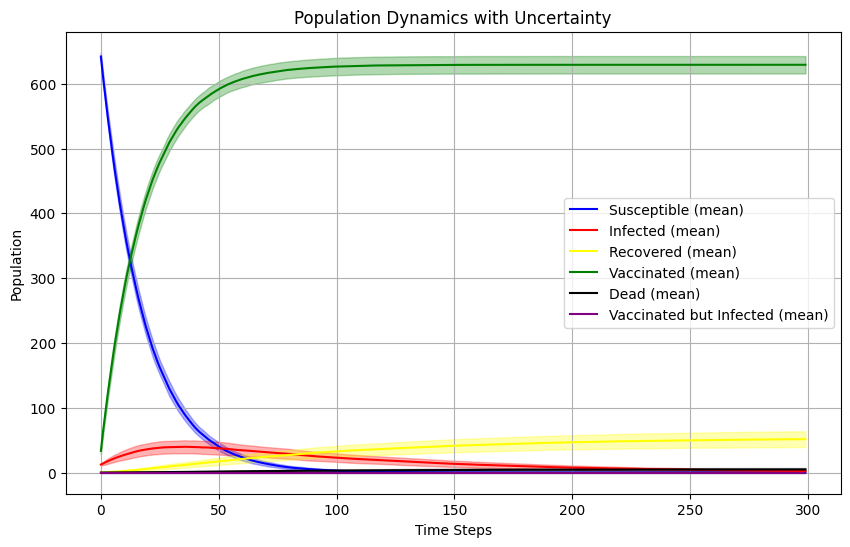

Estimated β: 3.263407737165384


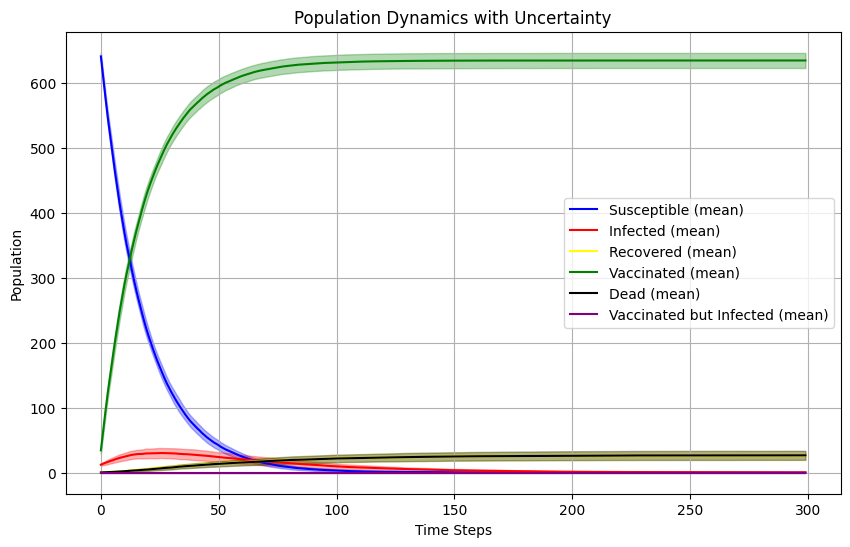

In [9]:
mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, mean_beta = model.run_simulation(num_runs=100, steps=300, initial_infected=10, p_recover=0.01, p_vaccinate=0.05, p_death=0.001, reinfection=0, p_death_vaccinated=0, p_recover_vaccinated=0, old_age_ratio=0, 
                vaccine_start_time=0, old_death_multiplier=0, old_stay_home_prob=0, home_radius=0)
model.plot_results(mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, steps=300)

mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, mean_beta = model.run_simulation(num_runs=100, steps=300, initial_infected=10, p_recover=0.01, p_vaccinate=0.05, p_death=0.01, reinfection=0, p_death_vaccinated=0, p_recover_vaccinated=0, old_age_ratio=0, 
                vaccine_start_time=0, old_death_multiplier=0, old_stay_home_prob=0, home_radius=0)
model.plot_results(mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, steps=300)

This is the results after implementing the possibility for an individual to be vaccinated. The first graph shows the results when we have the same death rate as before and the chance of getting vaccinated is set at 0.05. We see clear changes immediately, the number of people getting infected are drastically cut, also the number of deaths are zero. In the second graph we double the death rate and see that some people now die, but this is still very low compared to without the vaccine. There are some notes though: we have the vaccine from the start which is not normal when dealing with new types of viruses. Also the vaccinated are now immune, this is not normal either, during corona vaccinated people could still get infected but the death-rate was much lower. Going forward these notes are something we will try to implement. To conclude for this simulation we can see clear differences when including the chance of getting vaccinated.

#### Reinfection

Estimated β: 0.004782027773282931


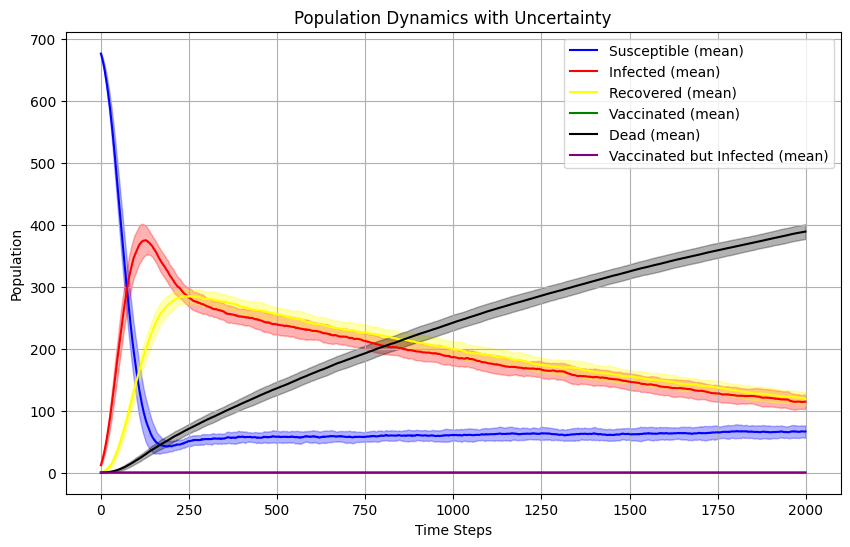

In [10]:
model = RandomWalkSIModel()
mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, mean_beta = model.run_simulation(num_runs=100, steps=2000, initial_infected=10, p_recover=0.01, p_vaccinate=0, p_death=0.001, reinfection=0.01, wave_period=0, wave_amplitude=0, p_death_vaccinated=0, p_recover_vaccinated=0,
                vaccine_start_time=0, old_age_ratio=0, old_death_multiplier=0, old_stay_home_prob=0, home_radius=0)
model.plot_results(mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, steps=2000)

We have now added the possibility of being reinfected after being recovered. We have taken vaccinated out of the simulation so we can focus on seeing the effect of reinfection. To introduce reinfection we check if a persons state is recovered and if it is there is a chance of the person being susceptible again. The result of reinfection is clear, we see a much higher death count and also the infection doesn't die out, the virus is more sustainable. For this simulation we have a large time step to be able to see changes over a longer time period, we see that the infection after its peak slows down but doesn't die out, at least not in our time step. When it comes to number of death we see that over half the population die, something which gives us an insight to how important vaccines are. 

#### Waves of infection

Estimated β: 0.004350028767133042


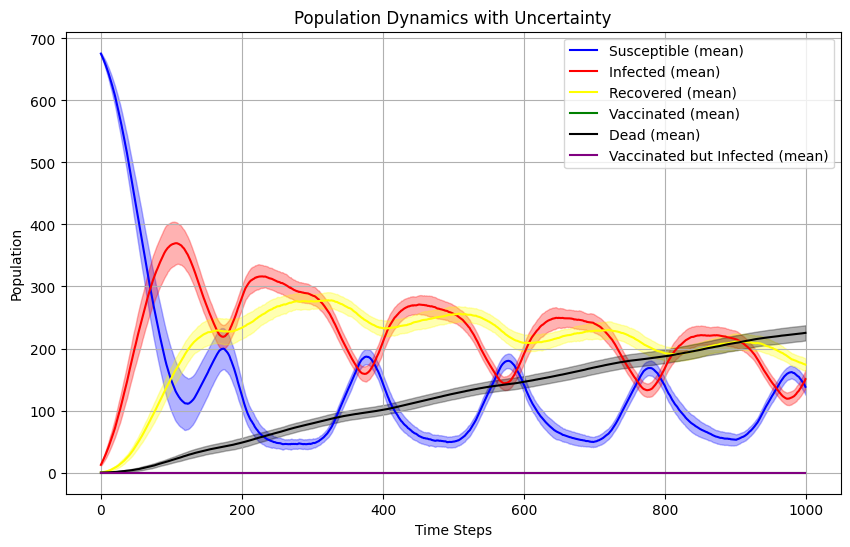

In [11]:
mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, mean_beta = model.run_simulation(num_runs=100, steps=1000, initial_infected=10, p_recover=0.01, p_vaccinate=0, p_death=0.001, reinfection=0.01, wave_period=200, wave_amplitude=1, p_death_vaccinated=0, p_recover_vaccinated=0, old_age_ratio=0, 
                vaccine_start_time=0, old_death_multiplier=0, old_stay_home_prob=0, home_radius=0)
model.plot_results(mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, steps=1000)

Like with corona we have now simulated infection waves, after a certain time step the infection rate changes. We see that the infected and the susceptible graphs are more like waves, the graphs also are dependent on each other, which makes sense since when many are infected there are less susceptible and so on. The death rate is similar to when we only have reinfection, but a little lower and its more consistent, but we also see some very small waves. The recovered graph is also behaving like a wave and also slows down after peaking early. We see that for each wave both the recovered and the infection graphs are smaller and smaller, while we see a little increase in susceptible over time.

#### Young and old people comparison

Estimated β: 0.009988440701525872


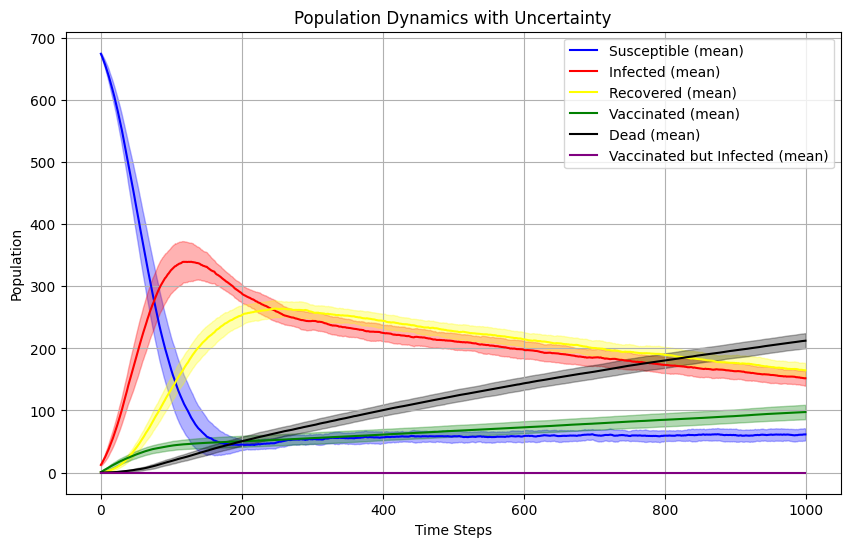

Estimated β: 0.009849114829373819
Age-specific deaths:
Young deaths (total): 141.08
Old deaths (total): 123.13


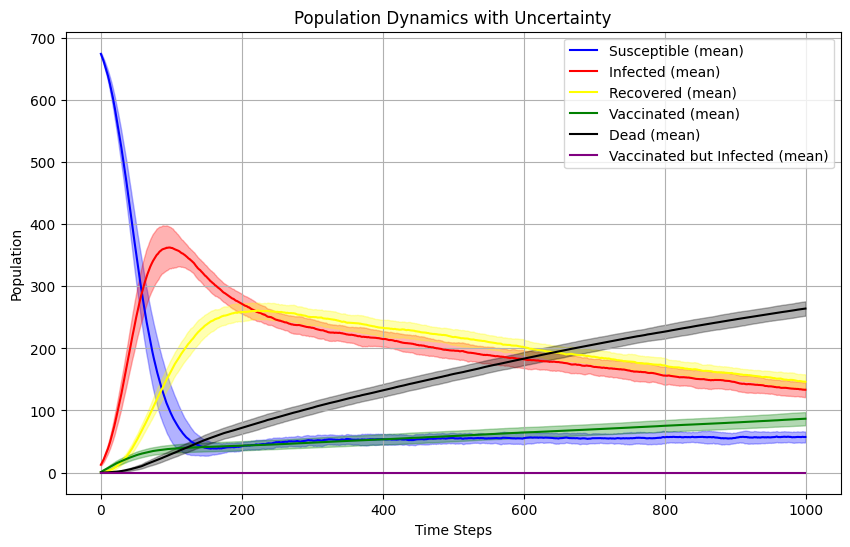

In [12]:
model = RandomWalkSIModel()
mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, mean_beta = model.run_simulation(num_runs=100, steps=1000, initial_infected=10, p_recover=0.01, p_vaccinate=0.001, p_death=0.001, reinfection=0.01, wave_period=0, wave_amplitude=0, p_death_vaccinated=0, p_recover_vaccinated=0,
                vaccine_start_time=0, old_age_ratio=0, old_death_multiplier=0, old_stay_home_prob=0, home_radius=0)
model.plot_results(mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, steps=1000)

mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, mean_beta = model.run_simulation(num_runs=100, steps=1000, initial_infected=10, p_recover=0.01, p_vaccinate=0.001, p_death=0.001, reinfection=0.01, wave_period=0, wave_amplitude=0, p_death_vaccinated=0, p_recover_vaccinated=0,
                vaccine_start_time=0, old_age_ratio=0.35, old_death_multiplier=2, old_stay_home_prob=0.5, home_radius=5)
model.plot_results(mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, steps=1000)

The Two different graphs show the same scenario, only the first one displays the deathrate without age discriminiation with a death rate of 0,1% chance of dying. The graph below it is with age discrimination, where older people (set at 35% of the populaton) have double the chance of dying of the virus than younger people. 

The change in death over 1000 steps is an increase of around 60 people with the age implemented, which is a significant change, taking in mind that it is the death of old people making this change.

#### Vaccinated people can get infected, die and spread infection

Estimated β: 0.08532018891701484
Age-specific deaths:
Young deaths (total): 51.89
Old deaths (total): 46.85


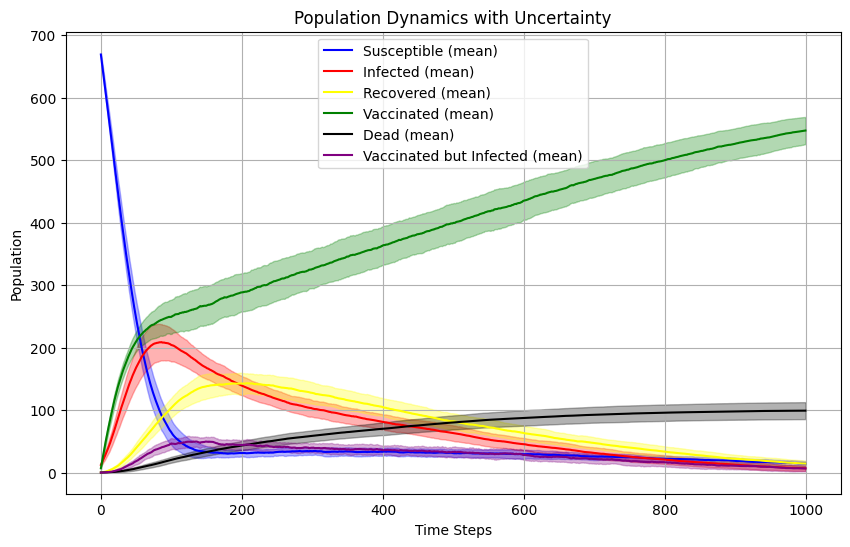

In [13]:
model = RandomWalkSIModel()
mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, mean_beta = model.run_simulation(num_runs=100, steps=1000, initial_infected=10, p_recover=0.01, p_vaccinate=0.01, p_death=0.001, reinfection=0.01, wave_period=0, wave_amplitude=0, p_death_vaccinated=0.00001, p_recover_vaccinated=0.1,
                vaccine_start_time=0, old_age_ratio=0.35, old_death_multiplier=2, old_stay_home_prob=0.5, home_radius=5)
model.plot_results(mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, steps=1000)

This graph implements that the people who are vaccinated can now get infected, shown by the purple graph, these infected but vaccinated have a much higher chance of recovering and a lower chance of dying, they can also still infect other people. We have set a low vaccination chance since we still have not implemented the fact that the vaccine often comes a while after the first breakout of infection. We see now that the vaccine has a big impact on how many people that get infected and a high impact on number of deaths.

Estimated β: 0.19284273315125325
Age-specific deaths:
Young deaths (total): 79.64
Old deaths (total): 76.52


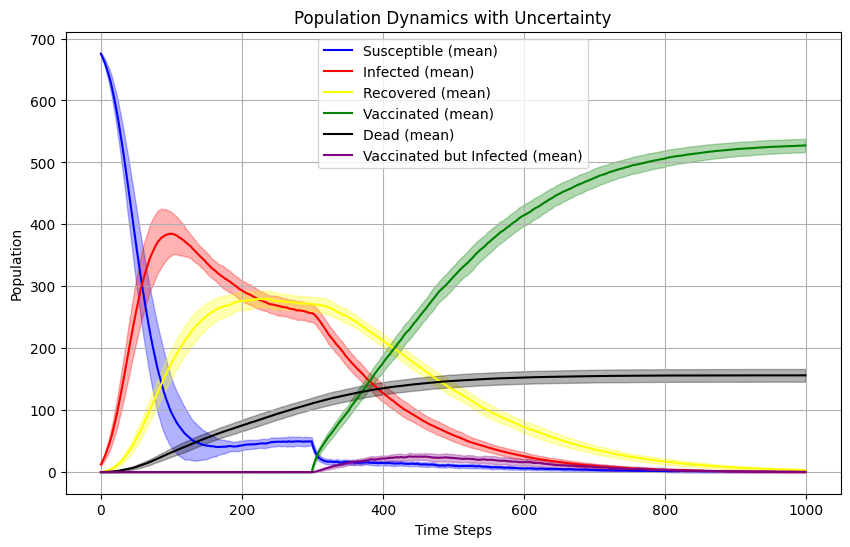

In [14]:
model = RandomWalkSIModel()
mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, mean_beta = model.run_simulation(num_runs=100, steps=1000, initial_infected=10, p_recover=0.01, p_vaccinate=0.1, p_death=0.001, reinfection=0.01, wave_period=0, wave_amplitude=0, p_death_vaccinated=0.00001, p_recover_vaccinated=0.1,
                vaccine_start_time = 300, old_age_ratio=0.35, old_death_multiplier=2, old_stay_home_prob=0.5, home_radius=5)
model.plot_results(mean_S, std_S, mean_I, std_I, mean_R, std_R, mean_V, std_V, mean_D, std_D, mean_VI, std_VI, steps=1000)

Finally we implement that the vaccine comes after some time period and is not available at the start of the outbreak. We now use a much higher vaccine chance which is much more realistic in our society. The effects of the vaccine are immense. We see that after the vaccine was introduced the number of deaths slowed down drastically, we also see that people getting reinfected is much lower and that the infection in the end dies out. In the infected graph you see a clear change after the vaccine has been introduced. The graphs of recovered and susceptible goes to 0 as well, this is because when you get vaccinated the state changed to vaccinated instead of susceptible, the vaccinated are still susceptible of course.

### Conclusion
In this project, we explored the dynamics of infectious disease spread using both a random-walk model and deterministic ODE-based models. Our simulations demonstrated the effects of factors such as infection probability, recovery, vaccination, reinfection, and death rates on population dynamics. We observed that while the random-walk model captures individual-level behaviors and spatial interactions, the ODE models provide a simplified and effective population-level view of disease progression.

Comparing the models, we found that while the outcomes were often similar, the random-walk approach showed greater variability and slower transitions between states due to its agent-based nature. Adding features like reinfection and age-based death probabilities helped to show how different parts of society affect the epidemic and the potential for recurring waves of infection. It also helped highlight the value of a vaccine, showing just how much the death rate and infection rate lowered once we introduced it. 

Ultimately, our findings makes it easier to understand the complexity of disease dynamics and the value of combining stochastic and deterministic approaches to gain a better understanding of epidemic outcomes and how we can affect them.


### Reflection

#### Stein Are:
This project was quite fun to work on, especially since it was covid simulations we were making, because it was something everyone saw for 4 years ago, for example on VG, where they had live graphs displaying infected, and deaths. During the project I learned a lot about the use of classes in python, further developed my skills in simulating scenarios and incidents, and communication. Throughout these projects our workflow have improved a lot, and coding skills all together improved too.

#### Lars:
During this project I have learned a great deal about simulations, in particular the Monte Carlo simulation we have used to create the random-walk. Using these simulations and plotting the results we have studied the effects of different parameters such as deaths, vaccines, different waves of infection and also age differences in the population. During the project I have also enhanced my python skills in particular with the use of classes and dictionaries. As a team we have improved in delegation and communication through these projects. 

#### Sanjai: 

I both enjoyed and disliked the concept of doing everything in one big class. On one hand, it was a cool challenge and i liked the fact that the tasks where done and shown by just a call of the class and its functions. But i will also admit that it was quite the hassle to problem-solve and debug such a huge class, and we spent a lot of time on errors that were probably simple, but hard to find due to its size. Nonetheless, it was a fun challenge, and i learned to like it along the way. As for the tasks themselves, I really liked the set up, teaching us how to do the SI and SIR model in the first two tasks, then allowing us to add our own elements in the third task was a fun twist, and i had fun thinking of how we would implement different elements like vaccination and age. All in all, even though this project was a lot of stress due to the size of the class and other exams/projects, it was a challenging way to improve both our creativity and problem-solving.

### References

- Covid cases, John Elflein, 30.08.23, Statista https://www.statista.com/statistics/1087466/covid19-cases-recoveries-deaths-worldwide/, 7.12.24.
- https://www.ibm.com/topics/monte-carlo-simulation 2.12.24
- https://ourworldindata.org/covid-deaths-by-vaccination 11.12.24
- https://gabgoh.github.io/COVID/ 09.12.24